#Hyperparameter Optimization
###Author: Andrew Mehrmann
###ASTR 596

* Hyperparameter: A model parameter that must be set outside of the actual model training
  * Traditional Parameters are learned from the data e.g. $\beta$ in linear regression
  * Hyperparameters are set manually, usually with the goal of controlling overfitting
 

Hyperparameter optimization refers to selecting values of hyperparameters such that they produce models that perform well on validation (test) data. Performance is assessed by some choice of one or many performance metrics.

* Performance Metric: A mathematical measure of how well a model performs, usually on validation (test) data. 
  * Examples: Accuracy, Precision, Recall, F1, ROC/AUC, MSE, Lift, etc.
  * Accuracy is *sometimes* a good metric, but often not as it assumes equal cost to both types of errors (FP, FN)
 
The choice of performance metric is extremely important to model assessment. Achieving 90% accuracy with a 90% target rate means you did about as good as the baseline assumption of positively classifying all observations.

This notebook will focus on two brute-force methods of hyperparameter optimization: Grid Search and Randomized search. Other methods include Bayesian optimization and gradient-based methods.

In [67]:
%matplotlib inline

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from collections import Counter

from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder 

####Load in and Inspect the Data

This data is the 2001 flight data from INFO 490. The column 'AirTime', has some missing values, which we will try to predict using the other variables.

In [72]:
df = pd.read_csv('2001.csv',encoding='latin-1',usecols=[1,3,8,10,12,13,16,17,18,21,23])
df=df[::1000]

categorical_vars = ['UniqueCarrier', 'Origin', 'Dest', 'Month','DayOfWeek', 'TailNum','Cancelled','Diverted']

for col in categorical_vars:
    df[col] = LabelEncoder().fit_transform(df[col]) 
    df[col] = df[col].astype(object)

df_notna = df[df['AirTime'].notnull()] # the data we can train on
df_withna = df[df['AirTime'].isnull()] # the data we want to impute


In [86]:
df_notna.shape # the data without na's for airtime

(5708, 11)

In [87]:
df_withna.shape # the data with na's for airtime

(260, 11)

In [76]:
df.shape # the dimensions of the whole dataset

(5968, 11)

In [77]:
# split the data into x and y
X = df_notna.drop('AirTime',axis=1)
y = df_notna['AirTime']

In [78]:
# the predictors
X.shape

(5708, 10)

In [79]:
# the response
y.shape

(5708,)

In [80]:
# datatype of the response
y.dtypes

dtype('float64')

In [81]:
# datatypes of the predictors
X.dtypes

Month             object
DayOfWeek         object
UniqueCarrier     object
TailNum           object
CRSElapsedTime     int64
Origin            object
Dest              object
Distance           int64
Cancelled         object
Diverted          object
dtype: object

####Define the classifier

In [101]:
forest = RandomForestRegressor(n_estimators = 100, random_state=91)

In [83]:
#a function to turn grid search scores into a dataframe
def get_data_frame(scores):
    df = pd.DataFrame(scores)
    df.columns = ['params','mean_score','scores']
    df['sd'] = df.scores.apply(np.std)
    df = df.drop('scores',axis=1)
    df_sorted = df.sort('mean_score', ascending=False)
    return df_sorted.head(10)

##Grid (Exhaustive) Search

* 'Exhaustive search over specified parameter values for an estimator.' - [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV)
*  'grid search, or a parameter sweep...is simply an exhaustive searching through a manually specified subset of the hyperparameter space of a learning algorithm' - [Wikipedia](https://en.wikipedia.org/wiki/Hyperparameter_optimization) 

###### Define the parameter space to search

In [89]:
feat_range = np.arange(1,X.shape[1],2)
depth_range = np.arange(1,21,3)
boot_range = [True, False]

params = {'max_features':feat_range,
         'max_depth':depth_range,
         'bootstrap':boot_range}

n_combos = len(feat_range) * len(depth_range) * len(boot_range)

print('the exhaustive search will examine {0} candidates'.format(n_combos))

the exhaustive search will examine 70 candidates


######Perform Grid Search and inspect the results

In [85]:
grid = GridSearchCV(forest, params, cv = 5, n_jobs=-1, scoring='mean_squared_error')

start = datetime.datetime.now()

grid_search = grid.fit(X,y)

elapsed = datetime.datetime.now() - start
print('{0} seconds elapsed during exhaustive search'.format(elapsed.seconds))

df_grid = get_data_frame(grid.grid_scores_)
df_grid

163 seconds elapsed during exhaustive search


,params,mean_score,sd
13,"{u'max_features': 7, u'bootstrap': True, u'max...",-90.786488,18.692227
17,"{u'max_features': 5, u'bootstrap': True, u'max...",-91.198049,18.902192
18,"{u'max_features': 7, u'bootstrap': True, u'max...",-91.914027,18.475632
22,"{u'max_features': 5, u'bootstrap': True, u'max...",-92.231863,17.732162
27,"{u'max_features': 5, u'bootstrap': True, u'max...",-92.246243,17.649197
14,"{u'max_features': 9, u'bootstrap': True, u'max...",-92.456793,18.389426
12,"{u'max_features': 5, u'bootstrap': True, u'max...",-92.572531,19.147717
33,"{u'max_features': 7, u'bootstrap': True, u'max...",-92.890291,18.634223
52,"{u'max_features': 5, u'bootstrap': False, u'ma...",-93.193447,18.194320
32,"{u'max_features': 5, u'bootstrap': True, u'max...",-93.303925,17.669478


We know for sure that the best possible model over this parameter space is the one selected by the Grid Search. We are interested in finding out whether or not we really need to calculated all of these (redundant) models, or if we can get away with calculating a random subset of them.

##Randomized Search

######Define the parameter space to search
* There is a new parameter *n_iter*
* The feature ranges are now defined as discrete distributions (this doesn't really matter here, but if the parameter space we were searching was continuous, sklearn advises that it's best to use continuous distributions).<sup>*</sup>

<sup>*</sup>" It is highly recommended to use continuous distributions for continuous parameters." - [sklearn docs](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.RandomizedSearchCV.html)

In [102]:
n_iter = 10

feat_range = sp_randint(1,X.shape[1])
depth_range = sp_randint(1,21)
boot_range = [True, False]


params = {'max_features':feat_range,
         'max_depth':depth_range,
         'bootstrap':boot_range}

print('the randomized search will examine {0} candidates'.format(n_iter))

the randomized search will examine 10 candidates


######Perform Randomized Search and inspect the results

In [103]:
rand = RandomizedSearchCV(forest, params, cv=5, n_jobs=-1, n_iter=n_iter, scoring='mean_squared_error', random_state=91)

start = datetime.datetime.now()

random_search = rand.fit(X,y)

elapsed = datetime.datetime.now() - start
print('{0} seconds elapsed during randomized search'.format(elapsed.seconds))

df_rand = get_data_frame(rand.grid_scores_)
df_rand

24 seconds elapsed during randomized search


,params,mean_score,sd
0,"{u'max_features': 6, u'bootstrap': True, u'max...",-91.569584,18.583897
2,"{u'max_features': 5, u'bootstrap': True, u'max...",-93.303925,17.669478
5,"{u'max_features': 6, u'bootstrap': True, u'max...",-93.328175,18.896409
1,"{u'max_features': 4, u'bootstrap': True, u'max...",-93.863623,17.182798
4,"{u'max_features': 3, u'bootstrap': False, u'ma...",-100.750272,16.989713
6,"{u'max_features': 8, u'bootstrap': False, u'ma...",-109.400205,20.378359
9,"{u'max_features': 2, u'bootstrap': False, u'ma...",-119.673723,16.474665
7,"{u'max_features': 2, u'bootstrap': True, u'max...",-164.637834,13.361455
8,"{u'max_features': 1, u'bootstrap': True, u'max...",-225.837746,32.969440
3,"{u'max_features': 1, u'bootstrap': True, u'max...",-302.469580,36.840713


This comparison shows that the best result from the randomized search is not statistically different than the best result from the grid search. This has two important implications:
1. The randomized search is more adaptable to huge data sets where computation time becomes unfeasable
2. Holding all else constant (including computation time), a randomized search allows us to search a larger parameter space.

Although it is not obvious that saving a couple minutes is a big deal, imagine these computation times were in hours or days.

######Perform repeated sampling to demonstrate

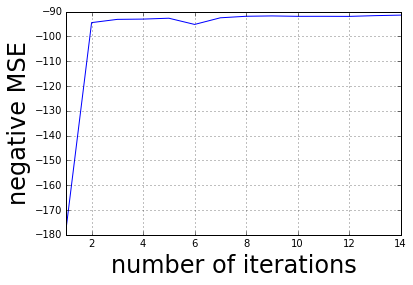

In [105]:
nrange = range(0,10)
iterange = range(1,15)
df_log = pd.DataFrame(index=iterange, columns=nrange)

for n in nrange:
    for n_iter in iterange:
        rand = RandomizedSearchCV(forest, params, cv=5, n_jobs=-1, n_iter=n_iter, 
                                  scoring='mean_squared_error', random_state=91)
        random_search = rand.fit(X,y)
        df_rand = get_data_frame(rand.grid_scores_)
        df_log.loc[n_iter][n] = df_rand.iloc[0].mean_score

plt.xlabel('number of iterations',size=24)
plt.ylabel('negative MSE',size=24)
df_log.mean(axis=1).plot() # plotting right from pandas series

##Pipelines

Pipelines allow you to chain functions together. This is useful when we want to optimize parameters on two or more functions. In this example, we first perfrom PCA on the data, then we perform our classification.  

*Note that this is a bad example statistically because PCA should not change our predictions much (it is simply a linear combination of the original variables). A real-world example would be text classification in which you would have to tune a text vectorizer and a classifier, or if you had very large data and wanted to reduce computation time

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from scipy.stats import uniform
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier

In [58]:
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

######Define pipeline and parameter space
* Note the new parameter **pc_range**
* Now that we have two function in a pipeline, we must specify which parameter belongs to which function

In [65]:
pca = PCA()
forest_class = RandomForestClassifier(n_estimators = 100, random_state=91)
# we have to specify names for the elements of the pipeline
# I've called pca 'components' and the random forest 'rfc'
pipeline = Pipeline([("components", pca), ("rfc", forest_class)])

feat_range = uniform(0,1)
depth_range = sp_randint(1,51)
boot_range = [True, False]
pc_range = sp_randint(1,X_digits.shape[1])

params = {'rfc__max_features':feat_range,
         'rfc__max_depth':depth_range,
         'rfc__bootstrap':boot_range,
         'components__n_components':pc_range}


######Perform Randomized Search and inspect the results

Notice that we simply pass the pipeline to the Randomized Search. 

In [66]:
search = RandomizedSearchCV(pipeline, params, cv=5, n_jobs=1, n_iter=10, scoring='accuracy', random_state=91)

start = datetime.datetime.now()

pipe_search = search.fit(X_digits,y_digits)

elapsed = datetime.datetime.now() - start
print('{0} seconds elapsed during randomized search'.format(elapsed.seconds))

df_pipe = get_data_frame(search.grid_scores_)
df_pipe

63 seconds elapsed during randomized search


,params,mean_score,sd
0,"{u'rfc__max_depth': 30, u'rfc__bootstrap': Tru...",0.929883,0.022405
1,"{u'rfc__max_depth': 10, u'rfc__bootstrap': Tru...",0.927101,0.024923
4,"{u'rfc__max_depth': 20, u'rfc__bootstrap': Fal...",0.922092,0.022713
5,"{u'rfc__max_depth': 42, u'rfc__bootstrap': Tru...",0.919866,0.017024
2,"{u'rfc__max_depth': 33, u'rfc__bootstrap': Tru...",0.916528,0.020357
7,"{u'rfc__max_depth': 27, u'rfc__bootstrap': Tru...",0.915415,0.028417
8,"{u'rfc__max_depth': 8, u'rfc__bootstrap': True...",0.904285,0.022453
6,"{u'rfc__max_depth': 31, u'rfc__bootstrap': Fal...",0.902615,0.026475
3,"{u'rfc__max_depth': 16, u'rfc__bootstrap': Tru...",0.895938,0.022642
9,"{u'rfc__max_depth': 18, u'rfc__bootstrap': Fal...",0.873122,0.020347


##Model Assessment

In practice, it is (sorta) acceptable to perform hyperparameter optimization on the entire dataset because the cross-validation scores are computed by fitting the model on a subset of the data and testing it on different data. After we have found the optimal values of hyperparameters, we can use them to train a model on training data to assess performance.

This step isn't totally necessary as we already have an estimate of our validation error, however we can access some extra functionality in scikit learn by doing it this way.

####Select and fit a model on training data

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, test_size=0.2, random_state=91)

In [93]:
forest = pipe_search.best_estimator_ # just grab the best estimator from before (the random search)
y_pred = forest.fit(X_train, y_train).predict(X_test)

####Confusion Matrices and Classification Reports

In [94]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [95]:
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

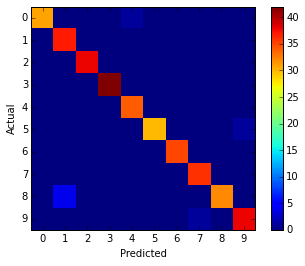

In [96]:
plt.imshow(df_confusion,interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(df_confusion.columns))
plt.xticks(tick_marks, df_confusion.columns)
plt.yticks(tick_marks, df_confusion.index)
plt.ylabel(df_confusion.index.name)
plt.xlabel(df_confusion.columns.name)

In [97]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       1.00      0.97      0.98        32
          1       0.90      1.00      0.95        37
          2       1.00      1.00      1.00        38
          3       1.00      1.00      1.00        42
          4       0.97      1.00      0.99        34
          5       1.00      0.97      0.98        31
          6       1.00      1.00      1.00        35
          7       0.97      1.00      0.99        36
          8       1.00      0.89      0.94        36
          9       0.97      0.97      0.97        39

avg / total       0.98      0.98      0.98       360



###References

* http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf
* http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html